In [1]:
%run Libraries.ipynb

In [2]:
class ObjectOrientedPorto:
    """

    """
    def __init__(self,train,test):
        
        """
        has 3 functions,1)  _get_all_data to merge train & test
        2)_info to get var types in the data, NA info etc
        3) describe_data to do descriptive stats
        """
        print("Object Oriented Porto Object Created")
        self.y_train=train['target']
        self.train=train.drop('target',axis=1)
        self.test=test
        self.train_len=train.shape[0]
        self.test_len=test.shape[0]
        
        #concat train and test data
        self.all_data=self._get_all_data()
        self._info=self._info()
        #self.describe_data=self.describe_data()
        
        
        
    def _get_all_data(self):
        """
        merge train and test to do basic Descriptive Stats analysis
        """
        return pd.concat([self.train,self.test],axis=0)

    
    def _info(self):
        """
        we will use this to manage the data. Call variables as per the var type,wheather to include them into modelling etc.
        """
        level=[]
        for feature in self.all_data.columns:
            if 'cat' in feature or feature=='id':
                level.append('nominal')
            elif 'bin' in feature:
                level.append('binary')
            elif train[feature].dtypes=='int64':
                level.append('ordinal')
            elif train[feature].dtypes=='float64':
                level.append('interval')
                
        meta=pd.DataFrame(level,columns=['level'])
        meta['role']=['id' if feature=='id' else 'input' for feature in self.all_data.columns]
        meta.index=self.all_data.columns
        meta['keep']=True        
        meta['dtype']=[self.all_data[feature].dtype for feature in self.all_data.columns]
        meta['Missing_Count']=list(map(lambda x: sum(self.all_data[x]==-1),self.all_data.columns))
        meta['Missing_Percent']=round(meta['Missing_Count']*100/self.all_data.shape[0],2)
        meta.loc[meta['Missing_Percent']>25, 'keep']=False
        meta.loc['id','keep']=False
        return meta
    
    def describe_data(self,var_type):
        """
        this output will help us understand the range,variance and if scaling is needed etc.
        """
        temp=self._info[(self._info.level==var_type) & (self._info.keep)].index
        print("{} Variable".format(var_type))
        print("=======================")
        return(self.all_data[temp].describe())

In [3]:
class Preprocess(ObjectOrientedPorto):
    
    def __init__(self,train,test,val_size=None):
        print("Preprocess Object Created")
        super().__init__(train,test)
        if val_size==None:
            self.val_size=0.3
        else:
            self.val_size=val_size
            
          
    
    def _get_train_test_val_split(self,val_size):
        """
        return a dic with keys X_train,y_train,X_val,y_val,X_test
        """
        data_dic={}
        self.train=self.all_data.head(self.train_len)
        self.test=self.all_data.tail(self.test_len)
        X_train, X_val,y_train, y_val=train_test_split(self.train,self.y_train,test_size=val_size,random_state=42)
        data_dic['X_train']=X_train
        data_dic['X_val']=X_val
        data_dic['y_train']=y_train
        data_dic['y_val']=y_val
        data_dic['X_test']=self.test
        return data_dic
        
        
    def fillna(self,val_size=None):
        """
        Keep nominal variables with NA as is (-1)
        Replace interval variables with NA by median
        Replace ordinal variables with NA by mode
        
        """
        if val_size==None:
            val_size=self.val_size
            
        get_data=self._get_train_test_val_split(val_size)
        info=self._info
        interval_features=(info [(info['keep'])&(info['Missing_Count']>0)& (info['level']=='interval')]).index
        ordinal_features=(info [(info['keep'])&(info['Missing_Count']>0)& (info['level']=='ordinal')]).index

        for i in interval_features:
            get_data['X_train'][i]=get_data['X_train'][i].replace(-1,get_data['X_train'][i].median())
            get_data['X_val'][i]=get_data['X_val'][i].replace(-1,get_data['X_train'][i].median())
            get_data['X_test'][i]=get_data['X_test'][i].replace(-1,get_data['X_train'][i].median())
        
        for j in ordinal_features:
            get_data['X_train'][j]=get_data['X_train'][i].replace(-1,get_data['X_train'][i].mode()[0])
            get_data['X_val'][j]=get_data['X_val'][i].replace(-1,get_data['X_train'][i].mode()[0])
            get_data['X_test'][j]=get_data['X_test'][i].replace(-1,get_data['X_train'][i].mode()[0])
            
        return get_data

    
            
    def check_cardinality(self):
        """
        Gives the number of distict levels for each categorical variable
        """
        info=self._info
        nominal_features=(info [(info['keep'])& (info['level']=='nominal')]).index
        
        for i in nominal_features:
            print('variable {} has {} distinct levels'.format(i,self.all_data[i].value_counts().shape[0]))
            
    def fix_cardinality(self,column_name):
        """
        data  a dic
        fix cardinality for a COLUMN ( variable that has too many dictinct levels). By P(1) 
        for that level or apriori if the level doesnot exist. This will give 3 series as output.
        Add them then to the data ( train, val, test ) with post script _TE ( target encoded )
        """
        data=self.fillna(val_size=None)
        #column_name='ps_car_11_cat'
        
        
        train_encoded,val_encoded, test_encoded= target_encode(data['X_train'][column_name],\
                                                               data['X_val'][column_name],data['X_test'][column_name],\
                                                               target=data['y_train']) 
        
        
        data['X_train'][column_name+'_TE']=train_encoded
        data['X_val'][column_name+'_TE']=val_encoded
        data['X_test'][column_name+'_TE']=test_encoded
        info=super()._info() #update the meta data
        info.loc[column_name,'keep']=False
        
        return (data,info)

In [5]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
porto_instance=ObjectOrientedPorto(train,test)
porto_instance.describe_data('nominal')

Object Oriented Porto Object Created
nominal Variable


,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat
count,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06
mean,1.358745e+00,4.171346e-01,4.069547e-01,8.293596e+00,8.299367e-01,7.255556e-01,6.560714e+00,9.100971e-01,8.322189e-01,1.328302e+00,9.921346e-01,6.225685e+01
std,6.636391e-01,4.933963e-01,1.353300e+00,2.508307e+00,3.757064e-01,2.154316e+00,5.500869e+00,3.472121e-01,3.736719e-01,9.787431e-01,9.156538e-02,3.300722e+01
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,1.000000e+00
25%,1.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,3.200000e+01
50%,1.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,1.000000e+00,0.000000e+00,7.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,6.500000e+01
75%,2.000000e+00,1.000000e+00,0.000000e+00,1.100000e+01,1.000000e+00,0.000000e+00,1.100000e+01,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,9.400000e+01
max,4.000000e+00,1.000000e+00,6.000000e+00,1.100000e+01,1.000000e+00,9.000000e+00,1.700000e+01,1.000000e+00,1.000000e+00,4.000000e+00,2.000000e+00,1.040000e+02


In [6]:
porto_instance.describe_data('interval')

interval Variable


,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06
mean,6.110305e-01,4.395943e-01,5.514848e-01,3.799519e-01,8.134878e-01,2.763614e-01,3.067355e+00,4.496817e-01,4.501073e-01,4.499718e-01
std,2.876763e-01,4.045123e-01,7.938159e-01,5.836187e-02,2.247024e-01,3.569623e-01,7.299510e-01,2.872071e-01,2.871817e-01,2.872136e-01
min,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,2.506191e-01,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e-01,2.000000e-01,5.250000e-01,3.162278e-01,6.710052e-01,3.339162e-01,2.828427e+00,2.000000e-01,2.000000e-01,2.000000e-01
50%,7.000000e-01,3.000000e-01,7.211103e-01,3.741657e-01,7.660406e-01,3.687818e-01,3.316625e+00,4.000000e-01,5.000000e-01,5.000000e-01
75%,9.000000e-01,6.000000e-01,1.001561e+00,4.000000e-01,9.061429e-01,3.964846e-01,3.605551e+00,7.000000e-01,7.000000e-01,7.000000e-01
max,9.000000e-01,1.800000e+00,4.423517e+00,1.264911e+00,4.031301e+00,6.363961e-01,3.741657e+00,9.000000e-01,9.000000e-01,9.000000e-01


In [7]:
porto_instance.describe_data('binary')

binary Variable


,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06
mean,3.934442e-01,2.571276e-01,1.637637e-01,1.856645e-01,3.729769e-04,1.633706e-03,9.401033e-03,1.002669e-03,6.606838e-01,1.206718e-01,1.543620e-01,1.232027e-01,6.277899e-01,5.544687e-01,2.875504e-01,3.492159e-01,1.527841e-01
std,4.885141e-01,4.370505e-01,3.700612e-01,3.888358e-01,1.930901e-02,4.038611e-02,9.650212e-02,3.164909e-02,4.734774e-01,3.257456e-01,3.612955e-01,3.286698e-01,4.833941e-01,4.970245e-01,4.526205e-01,4.767225e-01,3.597794e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [8]:
all_data=porto_instance.all_data
info=porto_instance._info
info.head()

,level,role,keep,dtype,Missing_Count,Missing_Percent
id,nominal,id,False,int64,0,0.00
ps_ind_01,ordinal,input,True,int64,0,0.00
ps_ind_02_cat,nominal,input,True,int64,523,0.04
ps_ind_03,ordinal,input,True,int64,0,0.00
ps_ind_04_cat,nominal,input,True,int64,228,0.02


In [9]:
#Data Preprocess
preprocess_instance=Preprocess(train,test)
preprocess_instance.check_cardinality()

Preprocess Object Created
Object Oriented Porto Object Created
variable ps_ind_02_cat has 5 distinct levels
variable ps_ind_04_cat has 3 distinct levels
variable ps_ind_05_cat has 8 distinct levels
variable ps_car_01_cat has 13 distinct levels
variable ps_car_02_cat has 3 distinct levels
variable ps_car_04_cat has 10 distinct levels
variable ps_car_06_cat has 18 distinct levels
variable ps_car_07_cat has 3 distinct levels
variable ps_car_08_cat has 2 distinct levels
variable ps_car_09_cat has 6 distinct levels
variable ps_car_10_cat has 3 distinct levels
variable ps_car_11_cat has 104 distinct levels


In [10]:
data_preprocess_cardinality,meta_data=preprocess_instance.fix_cardinality('ps_car_11_cat')

In [11]:
meta_data.head()

,level,role,keep,dtype,Missing_Count,Missing_Percent
id,nominal,id,False,int64,0,0.00
ps_ind_01,ordinal,input,True,int64,0,0.00
ps_ind_02_cat,nominal,input,True,int64,523,0.04
ps_ind_03,ordinal,input,True,int64,0,0.00
ps_ind_04_cat,nominal,input,True,int64,228,0.02


In [12]:
class Visualize:
    
    def __init__(self,data,meta_data):
        self.data=data
        self.meta_data=meta_data
        
        
    def barplots(self):
        """
        plots for each level of a nominal variable wrt the target variable 
        """
        nominal_vars=self.meta_data[(self.meta_data.level=='nominal') & (self.meta_data.keep==True)].index
        train=pd.concat([self.data['X_train'],self.data['y_train']],axis=1)
        for f in nominal_vars:
            plt.figure()
            fig, ax = plt.subplots(figsize=(5,3))
            # Calculate the percentage of target=1 per category value
            cat_perc = train[[f, 'target']].groupby([f],as_index=False).mean()
            cat_perc.sort_values(by='target', ascending=False, inplace=True)
            # Bar plot
            # Order the bars descending on target mean
            sns.barplot(ax=ax, x=f, y='target', data=cat_perc, order=cat_perc[f])
            plt.ylabel('% target', fontsize=18)
            plt.xlabel(f, fontsize=18)
            plt.tick_params(axis='both', which='major', labelsize=18)
            plt.show();
            
            
    def corplots(self,var):
        """
        plots for interval variables / ordinal variables 
        """
        interval_vars=self.meta_data[(self.meta_data.level=='interval') & (self.meta_data.keep==True)].index
        ordinal_vars=self.meta_data[(self.meta_data.level=='ordinal') & (self.meta_data.keep==True)].index
        
        if var=='interval':
            var=interval_vars
        else:
            var=ordinal_vars
            
        data=self.data['X_train']
        
        plt.subplots(figsize=(10,7))
        cmap = sns.diverging_palette(220, 10, as_cmap=True)
        sns.heatmap(train[var].corr(),annot=True,fmt='.2f',cmap=cmap);

In [13]:
viz=Visualize(data_preprocess_cardinality,meta_data)

<Figure size 432x288 with 0 Axes>

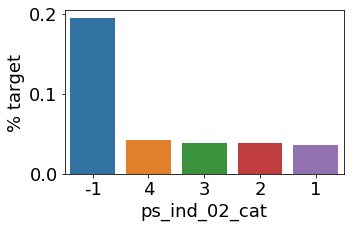

<Figure size 432x288 with 0 Axes>

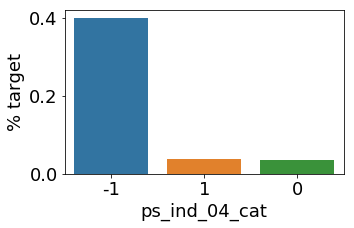

<Figure size 432x288 with 0 Axes>

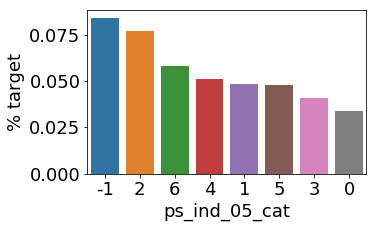

<Figure size 432x288 with 0 Axes>

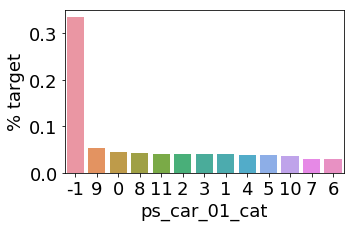

<Figure size 432x288 with 0 Axes>

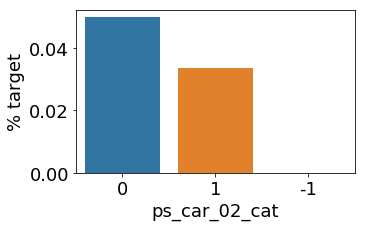

<Figure size 432x288 with 0 Axes>

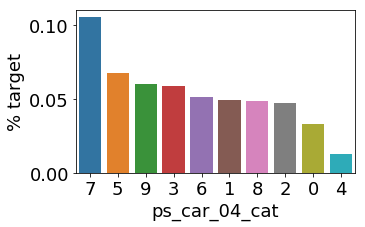

<Figure size 432x288 with 0 Axes>

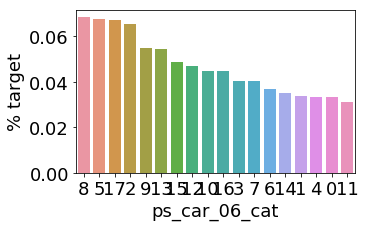

<Figure size 432x288 with 0 Axes>

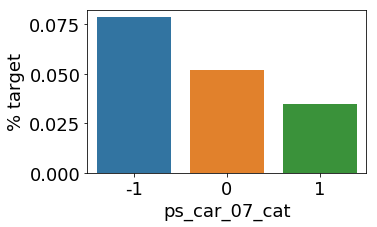

<Figure size 432x288 with 0 Axes>

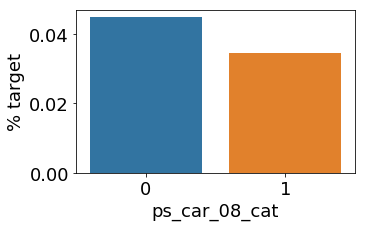

<Figure size 432x288 with 0 Axes>

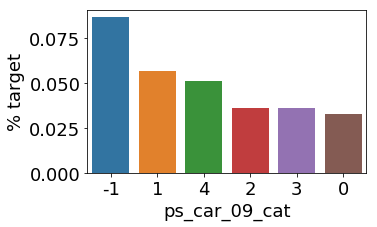

<Figure size 432x288 with 0 Axes>

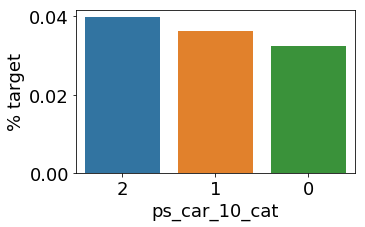

In [14]:
viz.barplots() #nominal variables

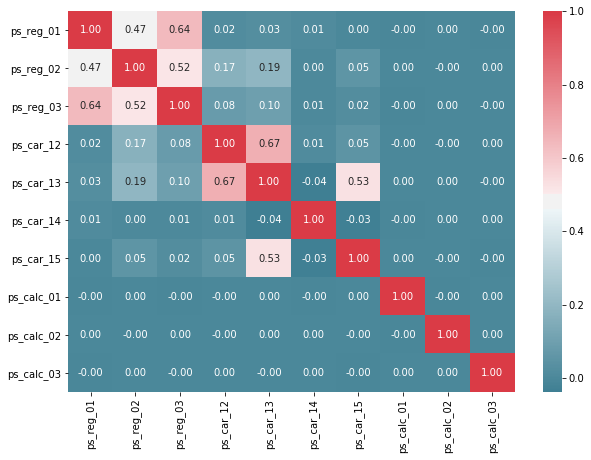

In [15]:
viz.corplots('interval')

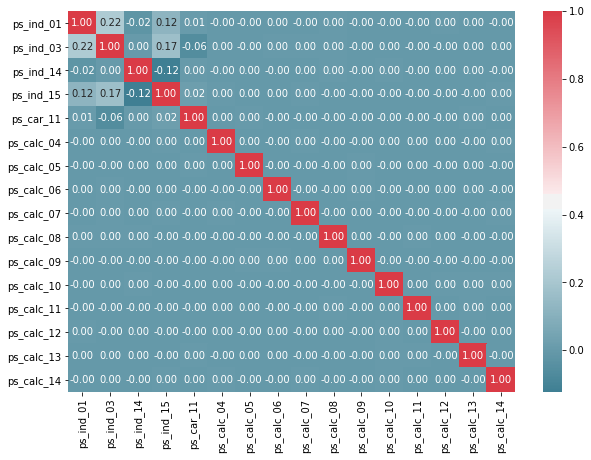

In [16]:
viz.corplots('ordinal')

In [17]:
class feature_engineering:
    def __init__(self,meta): 
        self.meta_data=meta
    
    def merge_data(self,data):
        self.data=data
        self.data['X_train']['data']='train'
        self.data['X_train']['target']=data['y_train']
        self.data['X_val']['data']='val'
        self.data['X_val']['target']=data['y_val']
        self.data['X_test']['data']='test'
        self.data['X_test']['target']=-1
        all_data=pd.concat([self.data['X_train'],self.data['X_val'],self.data['X_test']],axis=0)
        all_data.reset_index(drop=True,inplace=True)
        return all_data
    
        
    def create_dummies(self,data):
        data=self.merge_data(data)
        nominal_variables= meta_data[(meta_data.level == 'nominal') & (meta_data.keep)].index
        print('Before creating dummies- Total variables: {}'.format(data.shape[1]))
        data=pd.get_dummies(data, columns=nominal_variables, drop_first=True)
        print('After creating dummies- Total variables: {}'.format(data.shape[1]))
        return data
    
    def interaction_vars(self,data_dummy,degree):
        """
        interaction of all interval variables. Degree as input
        """
        self.data=data_dummy
        self.degree=degree
        
        interval_varaibles=meta_data[(meta_data.level == 'interval') & (meta_data.keep)].index
        print('Before creating interactions we have {} variables'.format(self.data.shape[1]))
        
        higher_order=PolynomialFeatures(degree=self.degree,interaction_only=False,include_bias=False)
        interactions=pd.DataFrame(data=higher_order.fit_transform(self.data[interval_varaibles]),\
                                  columns=higher_order.get_feature_names(interval_varaibles))
        
        #drop the original variables as interaction variables include the original variables too
        interactions.drop(interval_varaibles,axis=1,inplace=True)
        all_data_inter_vars = pd.concat([self.data, interactions], axis=1)
        print('After creating interactions we have {} variables'.format(all_data_inter_vars.shape[1]))
        return all_data_inter_vars

In [18]:
feature_eng_instance=feature_engineering(meta_data)
dummy_df=feature_eng_instance.create_dummies(data_preprocess_cardinality)

Before creating dummies- Total variables: 61
After creating dummies- Total variables: 113


In [20]:
df_interaction=feature_eng_instance.interaction_vars(dummy_df,2)

Before creating interactions we have 113 variables
After creating interactions we have 168 variables


In [26]:
del(dummy_df)

In [23]:
class featureSelection:
    
    def __init__(self):
        pass
    
    def var_threshold(self,data,value):
        self.data=data
        self.value=value
        
        selector = VarianceThreshold(threshold=self.value)
        selector.fit(self.data.drop(['id','data', 'target'], axis=1))
        f = np.vectorize(lambda x : not x)
        v = self.data.drop(['id','data', 'target'], axis=1).columns[f(selector.get_support())]
        print('{} variables have less than threshold variance.'.format(len(v)))
        print('These variables are {}'.format(list(v)))
        clean_data=self.data.drop(v,axis=1)
        print('Final Clean variable count {}'.format(clean_data.shape[1]))
        return clean_data
    
    def rf_var_importance(self):
        pass

In [24]:
fs_object=featureSelection()
clean_data=fs_object.var_threshold(df_interaction,0.01)

30 variables have less than threshold variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_11', 'ps_car_12', 'ps_car_14', 'ps_car_11_cat_TE', 'ps_ind_05_cat_2', 'ps_ind_05_cat_5', 'ps_car_01_cat_0', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_06_cat_12', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_09_cat_4', 'ps_car_10_cat_1', 'ps_car_10_cat_2', 'ps_car_12^2', 'ps_car_12 ps_car_14', 'ps_car_14^2']
Final Clean variables 138


In [27]:
class ML_algos:
    """
    Perform Grid Search and decide the best parameters on the val data. Use these best parameters
    to create a final model to predict on test
    """
    def __init__(self,data):
        self.data=data
        self.X_train=self.data[self.data['data']=='train'].drop(['data','target'],axis=1)
        self.X_val=self.data[self.data['data']=='val'].drop(['data','target'],axis=1)
        self.X_test=self.data[self.data['data']=='test'].drop(['data','target'],axis=1)
        self.y_train=self.data[self.data['data']=='train']['target']
        self.y_val=self.data[self.data['data']=='val']['target']
        
    def random_forest(self,params):
        self.params=params
        clf=RandomForestClassifier()
        grid_search_clf = GridSearchCV(clf, self.params, cv=5,n_jobs=-1,scoring='f1')
        grid_search_clf.fit(self.X_train,self.y_train)
        print(grid_search_clf.best_estimator_)
        val_pred=grid_search_clf.predict(self.X_val)
        return val_pred
        
    
    def xgb(self,params):
        self.params=params
        clf_xgb = XGBClassifier(objective = 'binary:logistic')
        clf = GridSearchCV(clf_xgb, \
            param_grid = self.params,cv=3,#To do Statified k fold use-->StratifiedKFold(train['Column'],n_folds=5,shuffle=True)
                early_stopping_rounds=1,scoring = 'roc_auc',verbose = 0, n_jobs = -1)
        clf.fit(self.X_train,self.y_train)
        print(clf.best_estimator_) #gives the best values of all paramters
        print(clf.best_params_) #gives the best values of the paramters (only from the grid search)
        print(clf.best_score_) #gives the best score on the objective of the classifier
        # clf.cv_results_  gives results as a table
        val_pred=clf.best_estimator_.predict_proba(self.X_val)
        return (val_pred[:,1])

In [28]:
ml=ML_algos(clean_data)

In [ ]:
#RANDOM FOREST
rf_params = {'n_estimators': [10,200],
              'max_features': ['log2','sqrt'], #, 'sqrt','auto'
              'criterion': [ 'gini'], #'entropy',
              'max_depth': [15,30],
              'min_samples_leaf': [20,30],
             'class_weight':['balanced']
             }
y_val_rf=ml.random_forest(rf_params)
printScore(y_val_rf,clean_data[clean_data['data']=='val']['target'])

In [126]:
%%time
#XGB
num_boost_round=3
xgb_params = {'eta': [0.02],
              'max_depth': [2,4], 
              'subsample':[ 0.6],
              'colsample_bytree': [0.5],
              'eval_metric': ['logloss']}

y_val_xgb=ml.xgb(xgb_params)
printScore(np.where(y_val_xgb>0.12,1,0),clean_data[clean_data['data']=='val']['target'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.5, eta=0.02,
       eval_metric='logloss', gamma=0, gpu_id=-1, importance_type='gain',
       interaction_constraints='', learning_rate=0.0199999996,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
       monotone_constraints='()', n_estimators=100, n_jobs=0,
       num_parallel_tree=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
       tree_method='exact', validate_parameters=1, verbosity=None)
{'colsample_bytree': 0.5, 'eta': 0.02, 'eval_metric': 'logloss', 'max_depth': 4, 'subsample': 0.6}
0.6213929189654477
Wall time: 9min 44s
